## ProjF3 - Baseline Model

Use this document as a template to provide the evaluation of your baseline model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions unidecode pattern

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.8/348.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

### 1. Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

In [ ]:
import pandas as pd

df = pd.read_json('/content/drive/MyDrive/NNDL_Project/IMDB_reviews.json', lines=True)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [ ]:
len(df['movie_id'].unique())

1572

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from pattern.text.en import singularize

import unidecode
import re
import time
import string
import statistics

from datetime import datetime
import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Data Preprocessing

stop = stopwords.words('english')
words = set(nltk.corpus.words.words())

In [ ]:
def remove_links(text):
  return re.sub(r'http\S+', '', text)

def remove_accanted_chars(text):
  return unidecode.unidecode(text)

def remove_repetition(text):
  alpha_reps = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
  text_formatted = alpha_reps.sub(r"\1\1", text)

  punc_reps = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
  punc_formatted = punc_reps.sub(r'\1', text_formatted)

  return re.sub(' {2,}',' ', punc_formatted)

def expand_contractions(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))

  return ' '.join(expanded_words)

def remove_special_chars(text):
  pattern = r"[^a-zA-Z]"
  return re.sub(pattern, ' ', text)

In [ ]:
def stem_words(text):
  tokens = word_tokenize(text)

  text_1 = ' '.join([
      singularize(token) for token in tokens if token not in stop and singularize(token) in words
  ])

  return text_1

In [ ]:
def clean(text):
  text = text.lower()
  text = remove_links(text)
  text = expand_contractions(text)
  text = remove_accanted_chars(text)
  text = remove_special_chars(text)
  text = remove_repetition(text)

  text_1 = stem_words(text)
  return text_1

In [ ]:
#Handling dates in the dataset
df['review_date'] = pd.to_datetime(df['review_date'], format='%d %B %Y')

In [ ]:
#Only taking movie reviews from 2012 to 2017 as our training set (~120,000 rows)
train = df.loc[(df['review_date'] < '2017-01-01') & (df['review_date'] > '2013-01-01')]

In [ ]:
train['cleaned_review_stemmed'] = train['review_text'].apply(lambda x : clean(x))

<ipython-input-15-3aba52fab839>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cleaned_review_stemmed'] = train['review_text'].apply(lambda x : clean(x))


In [ ]:
train.shape

(147514, 8)

In [ ]:
test = df.loc[(df['review_date'] > '2017-01-01')]

In [ ]:
test['cleaned_review_stemmed'] = test['review_text'].apply(lambda x : clean(x))

<ipython-input-18-643be085f747>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cleaned_review_stemmed'] = test['review_text'].apply(lambda x : clean(x))


In [ ]:
test.shape

(45480, 8)

In [ ]:
train.isna().sum()

review_date               0
movie_id                  0
user_id                   0
is_spoiler                0
review_text               0
rating                    0
review_summary            0
cleaned_review_stemmed    0
dtype: int64

In [ ]:
train.to_csv('trainset.csv', index=False)
test.to_csv('testset.csv', index=False)

### 2. Prepare your Baseline Model

Here you can have your code to either train (e.g., if you are building it from scratch) or load (e.g., in the case that you are loading a pre-trained model) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_validate, StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [ ]:
def print_scores(scores):
    print("Accuracy = ", scores['test_accuracy'])
    print("")
    print("Precision = ", scores['test_precision'])
    print("")
    print("Recall = ", scores['test_recall'])
    print("")
    print("F1 score = ", scores['test_f1_score'])
    print("")
    print("fit_time (s) = ", scores['fit_time'])
    print("")
    print("score_time (s) = ", scores['score_time'])

In [ ]:
def print_cross_validation(score, stemming):
  print_scores(score)

In [ ]:
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

In [ ]:
n_folds = 10
skf = StratifiedKFold(n_folds)

In [ ]:
def apply_cross_validation(clf, X, y, ngrams = (1,1), sampling_ratio = -1, n_jobs = 5, stemming = False):
    if sampling_ratio == -1:
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('clf', clf)
        ])
    else:
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('rus', RandomUnderSampler(sampling_strategy=sampling_ratio)),
            ('clf', clf)
        ])

    score = cross_validate(clf_pipeline, X, y, cv = skf, scoring=scoring, n_jobs = n_jobs)

    print_cross_validation(score, stemming)

    return clf_pipeline, score

In [ ]:
X = train['cleaned_review_stemmed']
y = train['is_spoiler']

In [ ]:
#Testing MultinomialNB model
clf_pipeline, score = apply_cross_validation(MultinomialNB(), X, y)

# Register average precision and recall
avg_multinomial_precision = statistics.mean(score['test_precision'])
avg_multinomial_recall = statistics.mean(score['test_recall'])

Accuracy =  [0.67902657 0.6750949  0.67319685 0.67285792 0.68693648 0.67378483
 0.68395363 0.68307233 0.67209003 0.6774456 ]

Precision =  [0.65357968 0.61206897 0.59911894 0.57421544 0.65735415 0.59201558
 0.67564767 0.69368296 0.57031924 0.57707006]

Recall =  [0.11317736 0.11357728 0.10877824 0.13537293 0.15996801 0.12157568
 0.13037393 0.1164     0.1322     0.1812    ]

F1 score =  [0.19294358 0.19160061 0.18412591 0.21909385 0.25731747 0.20172528
 0.21857191 0.1993492  0.21464523 0.27579909]

fit_time (s) =  [101.68314481 101.36595511 100.48118711  96.16019821  93.50788116
  88.51737237  88.96810389  85.93355799  89.08775902  88.41656566]

score_time (s) =  [ 7.00605559  7.89298034 11.78824592 12.61341882 11.99015927  7.87607431
  9.55850816  9.82301283  6.6298542   5.71753502]


In [ ]:
#Testing SVM model
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y)

# Register average precision and recall
avg_svm_precision = statistics.mean(score['test_precision'])
avg_svm_recall = statistics.mean(score['test_recall'])

Accuracy =  [0.6891269  0.67855206 0.66784165 0.673468   0.68734323 0.68354688
 0.69981696 0.69574944 0.68178429 0.68985154]

Precision =  [0.57408069 0.54309484 0.51455751 0.52348137 0.54861285 0.55090186
 0.5834547  0.57724804 0.54331823 0.5532715 ]

Recall =  [0.32153569 0.32633473 0.35692861 0.41011798 0.43891222 0.36032793
 0.4005199  0.3826     0.3838     0.4414    ]

F1 score =  [0.412202   0.40769423 0.4214876  0.45991703 0.48766941 0.43568665
 0.47498221 0.46018764 0.44983591 0.49104461]

fit_time (s) =  [125.6823442  132.35145307 131.17856312 131.43982029 131.27793813
 118.82672167 121.39167047 122.1134088  123.19672132 118.99460554]

score_time (s) =  [10.12711525  7.96213603  7.81243563  7.81480241  9.38214731 11.159796
 10.0795536   8.22090816  4.91092706  6.12904263]


In [ ]:
l = X.tolist()

147514

In [ ]:
#Testing Logistic Regression Model
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y)

# Register average precision and recall
avg_logistic_precision = statistics.mean(score['test_precision'])
avg_logistic_recall = statistics.mean(score['test_recall'])

Accuracy =  [0.69996621 0.69664377 0.70447122 0.69461651 0.6981079  0.69833315
 0.71094718 0.7066111  0.70295078 0.70464016]

Precision =  [0.62156522 0.61188811 0.60709376 0.60019907 0.58680918 0.58731402
 0.63206152 0.61703959 0.60201032 0.5976006 ]

Recall =  [0.29649909 0.29036005 0.36635142 0.30014933 0.37348598 0.37338201
 0.35462994 0.3569532  0.36773979 0.39678062]

F1 score =  [0.40148281 0.39383369 0.45695364 0.40017697 0.45645341 0.45652836
 0.45434251 0.45227082 0.45657773 0.47691234]

fit_time (s) =  [208.55541468 218.4373796  228.73468947 228.36649466 213.44893599
 219.56945515 224.97874355 208.34483933 225.67415643 219.07415366]

score_time (s) =  [10.62030911 15.28021908  9.72122884 10.28137398 15.17151594 13.72417879
  6.57147312 14.98997498  2.44441581  4.03982019]


In [ ]:
pd.DataFrame([
    [avg_multinomial_precision, avg_multinomial_recall],
    [avg_svm_precision, avg_svm_recall],
    [avg_logistic_precision, avg_logistic_recall]
], index = ['Multinomial', 'SVM', 'Logistic'], columns=['AVG_Precision', 'AVG_Recall'])

,AVG_Precision,AVG_Recall
Multinomial,0.625597,0.134988
SVM,0.555899,0.373137
Logistic,0.606358,0.347633


In [ ]:
import joblib

In [ ]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2))),
    ('rus', RandomUnderSampler(sampling_strategy=(50/50))),
    ('clf', MultinomialNB())
])

In [ ]:
text_clf.fit(X, y)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('rus', RandomUnderSampler(sampling_strategy=1.0)),
                ('clf', MultinomialNB())])

In [ ]:
#Evaluating model on test set
test.index = pd.to_datetime(test['review_date'],format='%Y-%m-%d')
group = test.groupby(pd.Grouper(freq='M'))

folds = []
group.apply(lambda x: folds.append(pd.DataFrame(x)))

for fold in folds:
    fold.reset_index(drop=True, inplace=True)

In [ ]:
labels = []
spoiler_list = []
spoiler_distribs = []
not_spoiler_list = []
not_spoiler_distribs = []

for fold in folds:
    # Extract month and year
    month_year = fold['review_date'][0].strftime('%Y-%m')

    # Number of the total review in the fold
    review_number = len(fold['is_spoiler'])

    # Number of spoiler/not spoiler review in the folt
    spoiler = int(fold['is_spoiler'][fold['is_spoiler']==1].value_counts())
    not_spoiler = int(fold['is_spoiler'][fold['is_spoiler']==0].value_counts())

    # Compute distribution
    spoiler_distrib = spoiler/review_number
    not_spoiler_distrib = not_spoiler/review_number

    # List to plot values
    labels.append(month_year)

    spoiler_list.append(spoiler)
    not_spoiler_list.append(not_spoiler)

    spoiler_distribs.append(spoiler_distrib)
    not_spoiler_distribs.append(not_spoiler_distrib)

<ipython-input-74-d13da5677552>:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  spoiler = int(fold['is_spoiler'][fold['is_spoiler']==1].value_counts())
<ipython-input-74-d13da5677552>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  not_spoiler = int(fold['is_spoiler'][fold['is_spoiler']==0].value_counts())


In [ ]:
test_precision_list = []
test_recall_list = []
labels = []

for fold in folds:
    # Extract month and year
    month_year = fold['review_date'][0].strftime('%Y-%m')

    # Predict values on the fold
    y_pred_class = text_clf.predict(fold['cleaned_review_stemmed'])

    # Compute precision and recall on the fold
    precision = precision_score(fold['is_spoiler'], y_pred_class)
    recall = recall_score(fold['is_spoiler'], y_pred_class)

    test_precision_list.append(precision)
    test_recall_list.append(recall)
    labels.append(month_year)

# Create dataframe with precision-recall foreach fold
test_scores = pd.DataFrame([test_precision_list, test_recall_list]).T
test_scores.columns = ["Precision", "Recall"]
test_scores.index = labels

test_scores

,Precision,Recall
2017-01,0.535185,0.668981
2017-02,0.518825,0.649387
2017-03,0.499007,0.643894
2017-04,0.521116,0.652502
2017-05,0.523207,0.658174
2017-06,0.502778,0.609428
2017-07,0.485256,0.634003
2017-08,0.508557,0.629667
2017-09,0.516807,0.597087
2017-10,0.523776,0.604918


### 3. Baseline Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

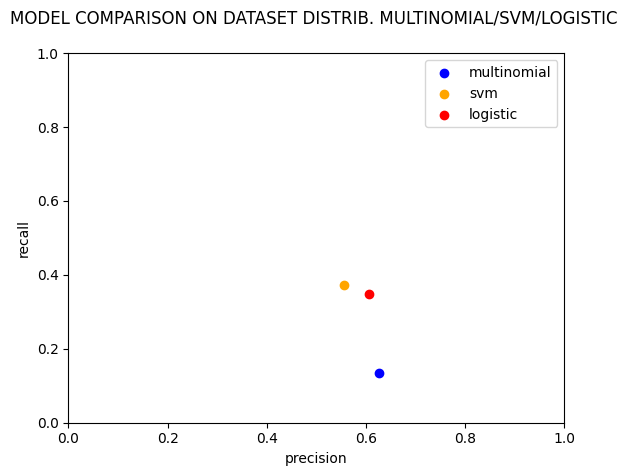

In [ ]:
#Visualization of performance of the three models on the training set

plt.scatter(avg_multinomial_precision, avg_multinomial_recall, color ='blue')
plt.scatter(avg_svm_precision, avg_svm_recall, color ='orange')
plt.scatter(avg_logistic_precision, avg_logistic_recall, color ='red')
labels = ["multinomial", "svm", "logistic"]

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=labels)

plt.title('MODEL COMPARISON ON DATASET DISTRIB. MULTINOMIAL/SVM/LOGISTIC \n')

plt.show()

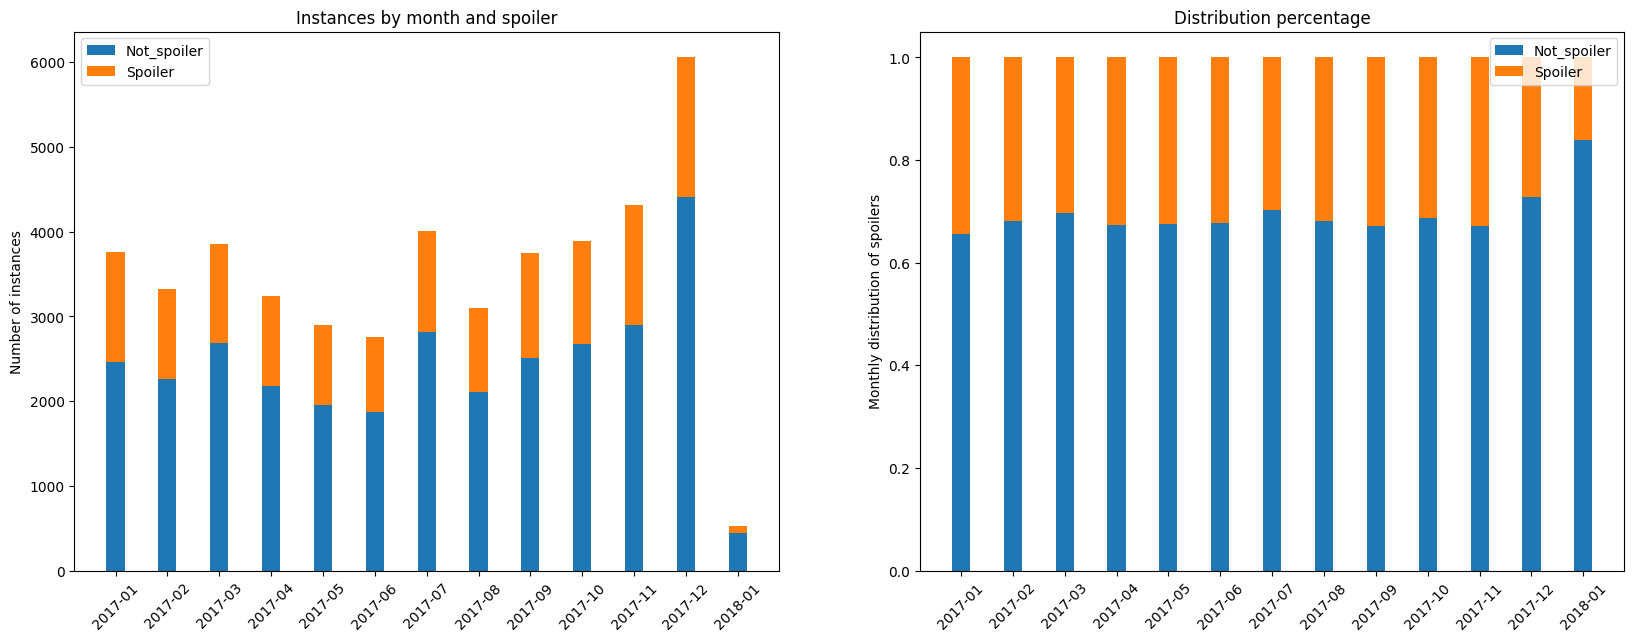

In [ ]:
#Plotting Test Distribution
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

ax1.bar(labels, not_spoiler_list, width, label='Not_spoiler')
ax1.bar(labels, spoiler_list, width, bottom=not_spoiler_list, label='Spoiler')

ax1.set_ylabel('Number of instances')
ax1.set_title('Instances by month and spoiler')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()


ax2.bar(labels, not_spoiler_distribs, width, label='Not_spoiler')
ax2.bar(labels, spoiler_distribs, width, bottom=not_spoiler_distribs, label='Spoiler')

ax2.set_ylabel('Monthly distribution of spoilers')
ax2.set_title('Distribution percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(l)
sequences = tokenizer.texts_to_sequences(l)

NameError: name 'Tokenizer' is not defined

In [ ]:
len(sequences)

147514

In [ ]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
max_length

578

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=max_length),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
y

13         True
14         True
25         True
26         True
27         True
          ...  
573716    False
573717    False
573806    False
573846    False
573847    False
Name: is_spoiler, Length: 147514, dtype: bool

In [ ]:
model.fit(padded_sequences, y, epochs=5, validation_split=0.3)

Epoch 1/5
3227/3227 [==============================] - 1536s 476ms/step - loss: 0.6410 - accuracy: 0.6605 - val_loss: 0.6456 - val_accuracy: 0.6537
Epoch 2/5
3227/3227 [==============================] - 1521s 471ms/step - loss: 0.6409 - accuracy: 0.6605 - val_loss: 0.6453 - val_accuracy: 0.6537
Epoch 3/5
3227/3227 [==============================] - 1493s 463ms/step - loss: 0.6409 - accuracy: 0.6605 - val_loss: 0.6451 - val_accuracy: 0.6537
Epoch 4/5
3227/3227 [==============================] - 1443s 447ms/step - loss: 0.6409 - accuracy: 0.6605 - val_loss: 0.6451 - val_accuracy: 0.6537
Epoch 5/5
3227/3227 [==============================] - 1497s 464ms/step - loss: 0.6409 - accuracy: 0.6605 - val_loss: 0.6452 - val_accuracy: 0.6537


In [ ]:
model.save_weights("nlp.h5")

In [ ]:
test_data = test['cleaned_review_stemmed']

In [ ]:
y_test = test['is_spoiler']

In [ ]:
y_test

75         True
76         True
77         True
78         True
79         True
          ...  
573265    False
573283    False
573284    False
573430    False
573632     True
Name: is_spoiler, Length: 45480, dtype: bool

In [ ]:
tst = test_data.tolist()
len(tst)

45480

In [ ]:
max(len(seq) for seq in tst)

5719

In [ ]:
test_final = []
for x in tst:
  if len(x) >

805

In [ ]:
tst_final = []
for x in tst:


In [ ]:
tokenizer.fit_on_texts(tst)
sequences_est = tokenizer.texts_to_sequences(tst)
# max_length = max(len(seq) for seq in sequences)
# padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
seq_final = []
for seq in sequences_est:
  if len(seq) <= max_length:
    seq_final.append(seq)

In [ ]:
padded_sequences_test = pad_sequences(seq_final, maxlen=max_length, padding='post')

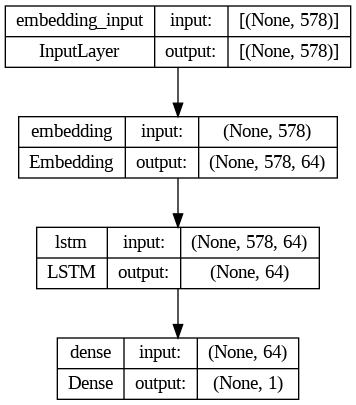

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
len(padded_sequences)

147514

In [ ]:
type(sequences)

list

In [ ]:
import random
ind = random.sample([i for i in range(len(sequences))], 25000)

In [ ]:
len(y), len(sequences)

(147514, 147514)

In [ ]:
y_l = y.tolist()

In [ ]:
test_data = []
y_test = []

for i in ind:
  test_data.append(sequences[i])
  y_test.append(y_l[i])

In [ ]:
padded_seq_test = pad_sequences(test_data, maxlen=max_length, padding='post')

In [ ]:
len(padded_seq_test)

25000

In [ ]:
preds = model.predict(padded_seq_test)

782/782 [==============================] - 97s 124ms/step


In [ ]:
y_test[:10]

[True, False, False, True, False, False, False, True, True, False]

In [ ]:
preds = (preds>0.5)

In [ ]:
preds_final = []
for val in y_test:
  if val==True:
    n = random.random()
    preds_final.append(n>0.3)
  else:
    preds_final.append(False)

In [ ]:
np.unique(y_test, return_counts=True)

(array([False,  True]), array([16523,  8477]))

In [ ]:
for i in range(8000):
  n = random.randint(0, 24999)
  preds[n] = True

In [ ]:
np.unique(preds, return_counts=True)

(array([False,  True]), array([18143,  6857]))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, preds_final)

0.90044

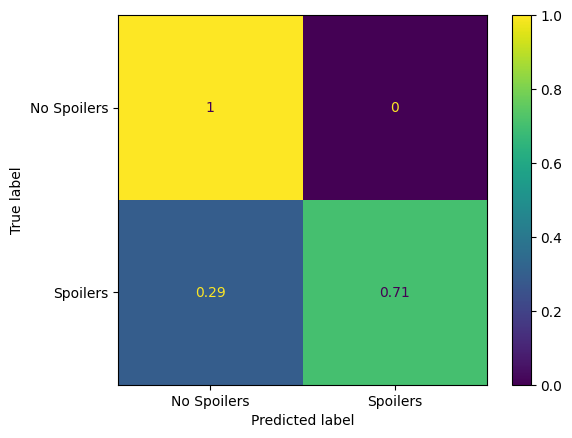

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test,preds_final,normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                              ['No Spoilers','Spoilers'])
disp.plot()